# Data Cleaning, Pre-processing, and Feature Engineering
## Detecting Gender Bias in Job Descriptions
## Project Overview

This notebook is part of a project aimed at detecting and mitigating gender bias in job descriptions using machine learning techniques. By applying natural language processing (NLP) methods to analyze text for gendered language patterns in job descriptions, algorithms were developed to identify patterns of gender bias. This contributes to ongoing efforts toward more inclusive hiring practices, ultimately reducing systemic gender disparities in the workforce.

## Steps in This Notebook

1. **Data Loading**: Load the dataset containing job descriptions.
2. **Data Cleaning**: Clean the job descriptions by removing stopwords and punctuation, and standardizing the text.
3. **Feature Engineering**: Extract features such as word frequencies, communal and agentic word counts, seniority level, and salary range.
4. **Visualization**: Visualize the distributions of communal and agentic scores and frequencies.
5. **Data Saving**: Save the cleaned data with the newly created features.
1. Removing Duplicates: Ensure there are no duplicate entries in the dataset.
1. Handling Missing Values: Address any missing values in the dataset.
1. Text Normalization: Normalize the text further by stemming or lemmatizing words.
1. Feature Scaling: Normalize numerical features to have similar scales.
1. Encoding Categorical Variables: Convert categorical variables into numerical format using techniques like one-hot encoding.
1. Adding More Features: Extract more meaningful features from the job descriptions.

## Keywords

- Gender bias
- Job descriptions
- Machine learning
- Natural language processing (NLP)
- Inclusive hiring practices

---



In [1]:
# Import necessary libraries
import pandas as pd
import nltk
import pycountry
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from textblob import TextBlob
from textstat import textstat

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('job_title_des.csv')

# Inspect the data
print(df.head())
print(df.info())

   Unnamed: 0             Job Title  \
0           0     Flutter Developer   
1           1      Django Developer   
2           2      Machine Learning   
3           3         iOS Developer   
4           4  Full Stack Developer   

                                     Job Description  
0  We are looking for hire experts flutter develo...  
1  PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...  
2  Data Scientist (Contractor)\n\nBangalore, IN\n...  
3  JOB DESCRIPTION:\n\nStrong framework outside o...  
4  job responsibility full stack engineer – react...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2277 non-null   int64 
 1   Job Title        2277 non-null   object
 2   Job Description  2277 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.5+ KB
None


In [3]:
# Clean the data
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation, and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

df['cleaned_description'] = df['Job Description'].apply(clean_text)

In [4]:
# Define communal and agentic words
communal_words = [
    'empathy', 'supportive', 'collaborative', 'kind', 'warm', 'compassionate', 
    'nurturing', 'cooperative', 'helpful', 'understanding', 'friendly', 'patient', 
    'approachable', 'loyal', 'trustworthy', 'caring'
]

agentic_words = [
    'ambition', 'independence', 'assertiveness', 'confident', 'competitive', 
    'leadership', 'proactive', 'self-reliant', 'dominant', 'persistent', 'decisive', 
    'driven', 'strategic', 'innovative', 'analytical', 'resilient'
]

def count_words(tokens, word_list):
    return sum(1 for token in tokens if token in word_list)

In [5]:
# Calculate communal and agentic scores
df['communal_score'] = df['cleaned_description'].apply(lambda x: count_words(x, communal_words))
df['agentic_score'] = df['cleaned_description'].apply(lambda x: count_words(x, agentic_words))

# Calculate frequency of communal and agentic words
df['communal_freq'] = df['communal_score'] / df['cleaned_description'].apply(len)
df['agentic_freq'] = df['agentic_score'] / df['cleaned_description'].apply(len)



In [6]:
# Ensure all entries in 'cleaned_description' are strings
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Add text length features
df['word_count'] = df['cleaned_description'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_description'].apply(lambda x: len(x))
df['avg_word_length'] = df['cleaned_description'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
df['sentence_count'] = df['cleaned_description'].apply(lambda x: len(TextBlob(x).sentences))
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']


In [7]:
# Add sentiment score
df['sentiment'] = df['cleaned_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [8]:
# Add readability scores
df['flesch_reading_ease'] = df['cleaned_description'].apply(lambda x: textstat.flesch_reading_ease(x))
df['flesch_kincaid_grade'] = df['cleaned_description'].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [9]:
# Extract seniority level from job titles
def extract_seniority(title):
    title = title.lower()
    if 'senior' in title or 'lead' in title or 'manager' in title or 'director' in title:
        return 'senior'
    elif 'junior' in title or 'assistant' in title or 'entry' in title:
        return 'junior'
    else:
        return 'mid'

df['seniority_level'] = df['Job Title'].apply(extract_seniority)

In [10]:
# Extract salary range from job descriptions (if salary information is present)
def extract_salary(description):
    # Example pattern to extract salary range; modify as needed based on actual data format
    salary_pattern = re.compile(r'\$\d{2,3}(?:,\d{3})*(?:-\$\d{2,3}(?:,\d{3})*)?')
    match = salary_pattern.search(description)
    if match:
        salary_str = match.group()
        if '-' in salary_str:
            lower, upper = salary_str.split('-')
            return (int(lower.replace('$', '').replace(',', '')) + int(upper.replace('$', '').replace(',', ''))) / 2
        else:
            return int(salary_str.replace('$', '').replace(',', ''))
    return None

df['salary'] = df['Job Description'].apply(lambda x: extract_salary(x) if isinstance(x, str) else None)

In [11]:
# Handle missing salary values if necessary (e.g., imputation, dropping, etc.)
df['salary'] = df['salary'].fillna(df['salary'].median())

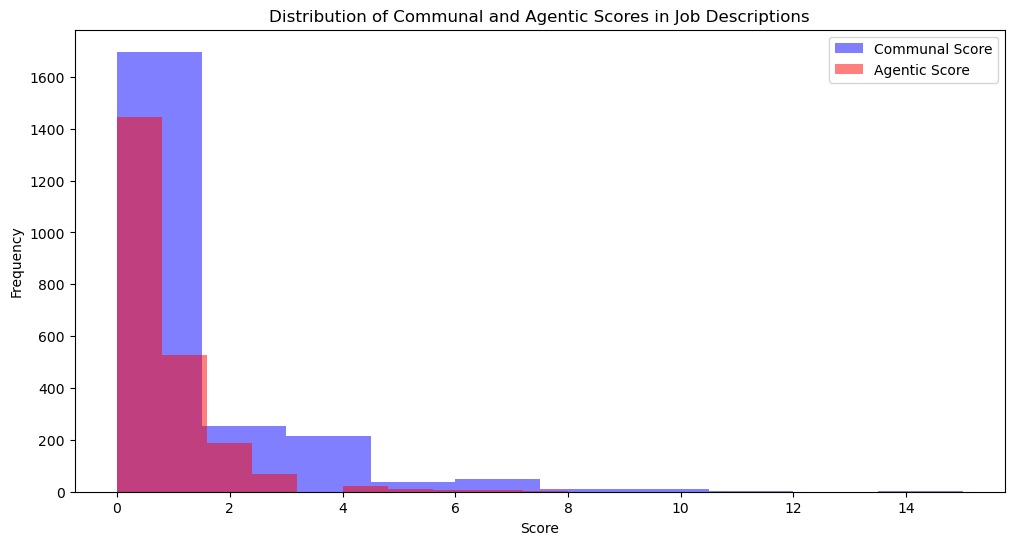

In [12]:
# Visualization
plt.figure(figsize=(12, 6))
df['communal_score'].plot(kind='hist', alpha=0.5, label='Communal Score', color='blue')
df['agentic_score'].plot(kind='hist', alpha=0.5, label='Agentic Score', color='red')
plt.legend()
plt.xlabel('Score')
plt.title('Distribution of Communal and Agentic Scores in Job Descriptions')
plt.show()

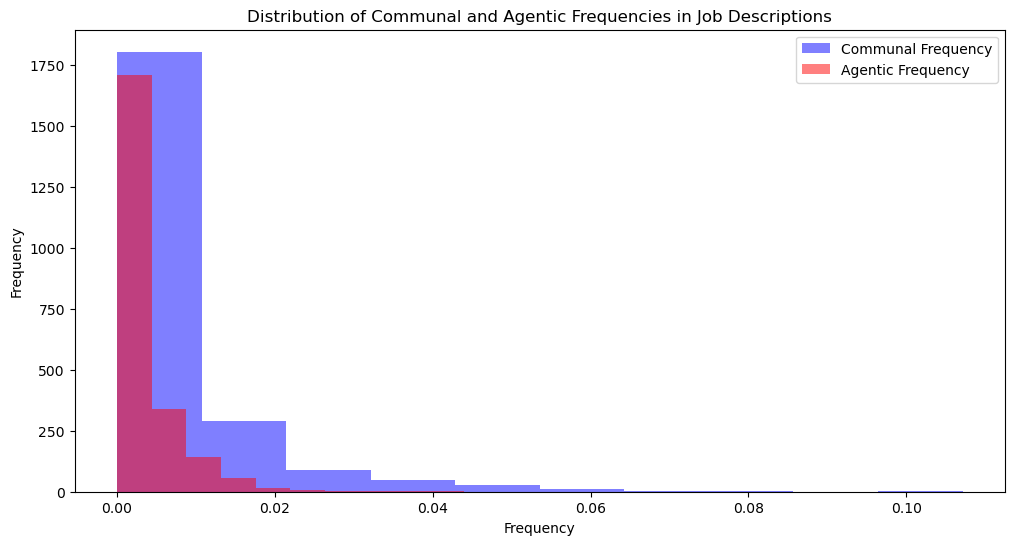

In [13]:
plt.figure(figsize=(12, 6))
df['communal_freq'].plot(kind='hist', alpha=0.5, label='Communal Frequency', color='blue')
df['agentic_freq'].plot(kind='hist', alpha=0.5, label='Agentic Frequency', color='red')
plt.legend()
plt.xlabel('Frequency')
plt.title('Distribution of Communal and Agentic Frequencies in Job Descriptions')
plt.show()

In [14]:
# Save the cleaned data with features to the current working directory
df.to_csv('cleaned_dataset.csv', index=False)

print("Data cleaning and feature extraction complete. Cleaned data saved to 'cleaned_dataset.csv'.")


Data cleaning and feature extraction complete. Cleaned data saved to 'cleaned_dataset.csv'.
